# Implementation of Representative Directions in a Numerical Model for the Mullins Effect in the Multiaxial Deformation of Elastomers

I propose a numerical model for modelling the behaviour of elastomers under deformations. The proposed model is based on a spherically oriented network of polydisperse N chain. It contains five physically motivated parameters and two computational parameters which need to be determined on the basis of experimental data.

The model is able to predict experimental results under uniaxial deformation, equibiaxial deformation and pure shear with excellent accuracy. The inclusion of a damage parameter allows for the prediction of the [Mullins effect](https://abaqus-docs.mit.edu/2017/English/SIMACAEMATRefMap/simamat-c-mullins.htm) and the innate representative directions due to the spherical orientation of the network predicts anisotropic softening in agreement with experiment.

This work is based on my [masters thesis](https://drive.google.com/file/d/1Sbm8yCoAqp042DqZWpC2vrmxCLPt74Et/view?usp=sharing) which I suggest reading for a full understanding of the model. I also suggest looking at [this](https://github.com/moe9195/SphereTriangulation/blob/master/sphere_triangulation_methods.ipynb) and [this](https://github.com/moe9195/RubberPhysics/blob/master/elastomers_deformation_models.ipynb) first to understand the functions used in this project. For any questions unanswered by the thesis, please feel free to email me your questions at [moerahmeh95@hotmail.com](mailto:moerahmeh95@hotmail.com).

In [1]:
#import relevant libraries
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(1)
np.random.seed(1)
np.seterr(divide='ignore', invalid='ignore');

In [2]:
#triangulates a sphere using the uniform grid method. Returns matrix of triangle vertices, M
def sphere_triangulation_grid(n, m):
    theta = np.linspace(0, 2*pi, num = n)
    phi   = np.linspace(0, pi, num = m)
    M     = np.zeros((3,3,(n-1)*(m-1)*2))
    ind   = 0
    for i in range(n-1):
        for j in range(m-1, 0, -1):
            x1u = cos(theta[i])*sin(phi[j])
            y1u = sin(theta[i])*sin(phi[j])
            z1u = cos(phi[j])
            
            x2u = cos(theta[i+1])*sin(phi[j])
            y2u = sin(theta[i+1])*sin(phi[j])
            z2u = cos(phi[j])
            
            x3u = cos(theta[i])*sin(phi[j-1])
            y3u = sin(theta[i])*sin(phi[j-1])
            z3u = cos(phi[j-1])
            
            x1l = x2u
            y1l = y2u
            z1l = z2u
            
            x2l = x3u
            y2l = y3u
            z2l = z3u
            
            x3l = cos(theta[i+1])*sin(phi[j-1])
            y3l = sin(theta[i+1])*sin(phi[j-1])
            z3l = cos(phi[j-1])
            
            M[:,:,2*ind]   = np.array([[x1u, x2u, x3u], [y1u, y2u, y3u], [z1u, z2u, z3u]])
            M[:,:,2*ind+1] = np.array([[x1l, x2l, x3l], [y1l, y2l, y3l], [z1l, z2l, z3l]])
            ind += 1
    return M                            #outputs a 3x3xN array; each 3x3 subarray represents a triangle.. 
                                        #...on the sphere where each row represents the xyz coordinates..
                                        #...of each vertex          

In [3]:
#arsNorm(A) and arsUnit(A,radius) are used to normalise and project the vertices onto the sphere
def arsnorm(A):
    return np.sum(np.abs(A)**2,axis=0)**(1./2)

#def arsNorm(A):
#   return np.sqrt(np.multiply(A[:,0],A[:,0]) + np.multiply(A[:,1],A[:,1]) + np.multiply(A[:,2],A[:,2]))

def arsunit(A, radius):
    normOfA = arsnorm(A.transpose())
    return  radius*(np.divide(A,np.transpose(np.vstack((normOfA,normOfA,normOfA)))))

#triangulates a sphere using octahedron method. Returns matrix of triangle vertices, M
def sphere_triangulation_octahedron(iterations, radius):
    #basic Octahedron
    A = np.array([1,0,0])
    B = np.array([0,1,0])
    C = np.array([0,0,1])
    #from +-ABC create initial triangles which define the octahedron
    triangles = np.vstack((A,B,C,A,B,-C,-A,B,C,-A,B,-C,-A,-B,C,-A,-B,-C,A,-B,C,A,-B,-C)) 
    #for simplicity, we split the triangles into ABC points
    selector  = np.arange(1,triangles.shape[0]-1,3)
    Ap = triangles[selector-1]
    Bp = triangles[selector]
    Cp = triangles[selector+1]
    
    #for every iteration divide every triangle into three new triangles
    #        ^ C
    #       / \
    # AC/2 /_4_\CB/2
    #     /\ 3 /\
    #    / 1\ /2 \
    # A /____V____\B           
    #       AB/2
    #the new triangle stack is given by [[A, AB/2, AC/2]; [AB/2, B, CB/2]; [AC/2, AB/2, CB/2]; [AC/2, CB/2, C]] 
    for iteration in range(1, iterations+1):
        AB_2 = arsunit((Ap+Bp)/2,radius)
        AC_2 = arsunit((Ap+Cp)/2,radius)
        CB_2 = arsunit((Cp+Bp)/2,radius)
        Ap   = np.vstack((Ap, AB_2, AC_2, AC_2))   #points from the 4 triangles... same for Bp and Cp
        Bp   = np.vstack((AB_2, Bp, AB_2, CB_2))
        Cp   = np.vstack((AC_2, CB_2, CB_2, Cp))
        
    M = np.array([Ap,Bp,Cp])            #outputs a 3x3xN array; each 3x3 subarray represents a triangle.. 
    M = np.transpose(M,(2,0,1))         #...on the sphere where each row represents the xyz coordinates..
                                        #...of each vertex          
    return M

In [4]:
#calculates determinant of 3x3 matrix. This is faster than using numpy.linalg.det() for 3x3 matricies
def det3(a):
    return (a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2]))

#calculates solid angle of spherical triangles using the vertices matrix M
def solid_angle(M):
    #initialise the solid angle array
    s = np.shape(M)
    omega = np.zeros([1,s[2]])
    #for each triangle we calculate the individual solid angles and add them to the solid angle array
    for i in range(s[2]):
        X = M[:,:,i]
        R1, R2, R3 = X[:,0], X[:,1], X[:,2]
        N = arsnorm(X)
        n1, n2, n3 = N[0], N[1], N[2]
        D = abs(det3(X))
        A = D/((n1*n2*n3) + ((np.dot(R1,R2)*n3) + (np.dot(R1,R3)*n2) + (np.dot(R2,R3)*n1)))
        omega[0,i] = atan(A)*2      
    return omega


In [5]:
#calculates coordinates of spherical triangle centroids using vertices matrix M
def spherical_triangle_centroid(M):
    #initialise the centroid 2d array
    s = M.shape
    C = np.zeros([3,s[2]])
    for i in range(s[2]):
        #getting the vertex vectors of the triangles
        X = M[:,:,i]
        R1 = X[:,0]
        R2 = X[:,1]
        R3 = X[:,2]
        #calculating xyz position of centres and projecting onto the sphere
        temp = (R1+R2+R3)/3
        temp = temp/np.linalg.norm(temp)
        #updating C with the xyz coordinates of the centroids
        C[:,i] = temp
    return C

In [6]:
'''
takes a vector lam (principle stretch ratio) and outputs the three principle stretch ratios in the xyz
directions in accordance wit the specified deformation type, t
'''
def deform(lam, t):
    #uniaxial deformation
    if t == 1:
        lam1 = lam
        lam2 = np.reciprocal(np.sqrt(lam1))
        lam3 = lam2
    #equibiaxial deformation
    elif t == 2:
        lam1 = lam
        lam2 = lam
        lam3 = np.reciprocal(lam**2)
    #pure shear
    elif t == 3:
        lam1 = lam
        lam2 = np.ones((1, lam.size))
        lam3 = np.reciprocal(lam1)
    else: return null
    #return 3xM matrix where M is lam.size
    return np.vstack((lam3,lam2,lam1))   

In [7]:
#returns the inverse Langevin of x
def inverse_langevin(x):
    return (x<0.99)*x*(3-x**2)/(1-x**2)

In [8]:
'''
returns the entropy of each chain, the force exerted on each chain, and the total force exerted...
on the network. r is a matrix made up of individual chain lengths as they undergo deformation...
omega is the solid angle of the triangle representing each chain, n0 are the chain lengths, G is...
a the shear modulus and h is the step size used for differentiation
'''
def force(r,omega,n0,G,h):
    b = inverse_langevin(r/np.sqrt(n0))
    s = (r>0)*omega*(G*np.sqrt(n0)*((r*b)  + np.log(b/np.sinh(b)))) + (r<=0)*0  #entropy of chains
    f = np.diff(s, axis=0)/h #force of chains
    f[np.isnan(f)] = 0
    F =(1/(4*pi))* np.sum(f,1); #total force on the network
    return s, f, F

In [9]:
'''
this function takes physical parameters and deformation behaviour and returns the loading and unloading
stress-strain curve for the elastomer. n is the average number of links per chain, N is the chain density per 
unit sphere, G is the shear modulus, h is the step size for numerical differentiation, tolerance is the maximum percent tolerance before
the chain breaks, lam_max is the maximum stretch ratio, defType determines the deformation type (1 for uniaxial,
2 for equibiaxial and 3 for pure shear), and distType determines the chain distrubution type (1 for uniform grid
distribution and 2 for octahedron method)
'''

def stress_strain_relation(n, N, G, h, std, tolerance, lam_max, defType, distType):
    np.random.seed(1)
    lam = np.arange(1,lam_max+h,h) #stretch ratio vector   
    #depending on distType calculate triangles matrix
    if distType == 1:
        N0 = round(1 + (sqrt(N)/sqrt(2)));
        M = sphere_triangulation_grid(N0, N0)
    else:
        N0 = round(log(N/8)/(2*log(2)))
        M = sphere_triangulation_octahedron(N0, 1)

    omega0 = solid_angle(M) #solid angle of spherical triangles
    Points = spherical_triangle_centroid(M) #calculate xyz coordinates of spherical triangles' centre
    rd = deform(lam, defType)
    #deformation vectors along the xyz directions for each chain
    rx, ry, rz = np.outer(rd[0,:],Points[0,:],), np.outer(rd[1,:],Points[1,:],), np.outer(rd[2,:],Points[2,:],)
    r  = np.sqrt((rx**2) + (ry**2) + (rz**2)) #magnitude (length) of each chain under deformation
    wd, ln = r.shape[0], r.shape[1] #wd is length of deformation vector; ln is length of chains vector

    '''
    we a assume chain length distribution that follows a log-normal distribution
    where the average number of links in each chain is given by n
    '''
    mu  = log(n/sqrt(1 + ((std**2)/(n**2)))) # adjusted mean for log-normal distribution
    sig = sqrt(log(1+((std**2)/(n**2))))     # adjusted sigma for log-normal distribution
    n0  = np.random.lognormal(mean=mu, sigma=sig, size=ln) # chain lengths
    '''
    we 'break' chains that exceed their maximum allowed length (set by the tolerance) by setting
    their length to 0. Then we calculate the forces on the chains to obtain the loading curve.
    '''                        
    r[r>np.sqrt(n0)*tolerance] = 0 
    s, f, F = force(r,omega0,n0,G,h)
    '''
    For the unloading curve, we remove the contribution of all the broken chains and recalculate
    the forces on the unbroken chains
    '''
    a0   = r[wd-1,:]
    rnew = r[:,~(a0==0)]
    #xb, yb, zb = x[(a0==0)], y[(a0==0)], z[(a0==0)]
    omeganew = omega0[0,~(a0==0)]
    nnew = n0[~(a0==0)]
    snew,fnew,Fnew = force(rnew,omeganew,nnew,G,h)
    lam0 = 100*np.delete(lam, -1)
    return lam0, F, Fnew                #return stretch ratio lam0, loading curve F and unloading curve Fnew


In [10]:
def plot_relation(lam0, F, Fnew, fig):
    fig.set_figheight(6)
    fig.set_figwidth(5)
    plt.ylim([0,np.max(F)+0.01])
    plt.margins(0,0)
    plt.plot(lam0, F, 'k', lam0, Fnew, 'k')
    plt.grid()
    plt.xlabel('Stretch ratio (%)')
    plt.ylabel('Tensile force (N)')
    plt.title('Stress Strain Relation')

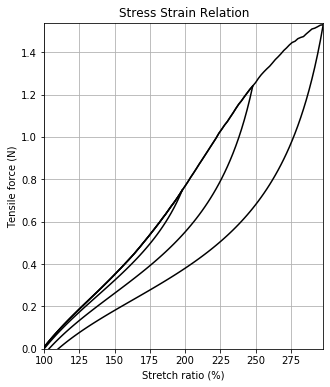

In [11]:
h, defType, distType, n, G, N, tolerance, std = 0.02, 1, 1, 10, 0.135, 100000, 0.9, 5

lam_max = np.linspace(2,3,3)
fig = plt.figure()
for i in lam_max:
    lam0, F, Fnew = stress_strain_relation(n, N, G, h, std, tolerance, i, defType, distType)
    plot_relation(lam0,F,Fnew, fig)
plt.show()
  